### Micrograd is a tiny autograd engine. An autograd engine is used to implement backpropogation.

Backprop is used to calculate the derivate of the output with respect to the inputs. We then use this value to adjust the inputs to minimize the loss function.

### 1. Understanding what a derivative is intuitively

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

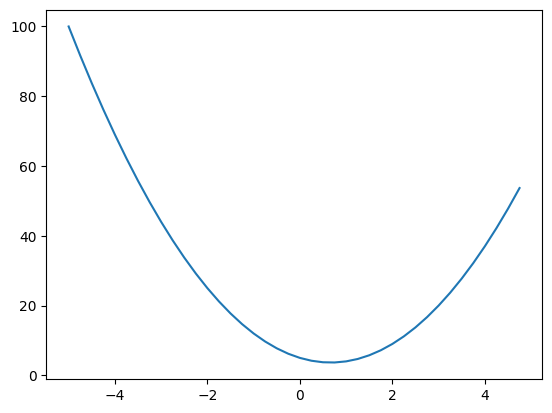

In [4]:
xs = np.arange(-5, 5, 0.25) # array of values from -5 to 5, in steps of 0.25, not including 5
ys = f(xs) # applies the function on all of the values in xs
plt.plot(xs, ys)

In [5]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h # the slope of the graph at the point x=3 (aka the derivative at x=3)
# at 3, the slope is 14

0.0

In [6]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h  
d2 = a*b + c # if we think this through, d2 would be smaller, because a will be slightly higher and b is a negative number, so the overall value is lower

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


### 2. Building out the Value object

In [3]:
class Value: 
    def __init__(self, data, _children=(), _op='', label=''): # children is to get the child values and op is to get the operation 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # a set of the children tuples
        self._op = _op
        self.label = label
        # we initialize children as a tuple for efficiency but define prev as a set for increased efficiency

    # repr function is just to show the output nicely
    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # checks if other is alr an instance of Value and if it isn't, creates an instance
        # ^ allows us to add Value objects directly to integers
        out = Value(self.data + other.data, (self, other), '+') # the plus operator is just floating point addition and we're wrapping that sum in a value object

        def _backward():
            self.grad += 1.0 * out.grad # addition gradient is just the value of the value
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # checks if other is alr an instance of Value and if it isn't, creates an instance
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # x1.grad = w1 * x1w1.grad
            other.grad += self.data * out.grad # w1.grad = x1 * x1w1.grad
        out._backward = _backward 
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}') 

        def _backward(): 
            self.grad += other * (self.data**(other-1)) * out.grad # power rule gives local gradient and we multiply by out.grad to get final gradient
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other # performs other + self (fallback function for python if we're adding int + Value, which doesn't work)

    def __rmul__(self, other):
        return self * other # performs other * self
        # this is used to allow us to do 2 * a, isntead of only a * 2, since python will check for a rmul fallback function and perform that operation with the values swapped

    def __truediv__(self, other): # self/other
        return self * other**-1
    # instead of directly implementing division, we implement exponentiation, which is more powerful and versatile and easier to differentiate
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # multiplying out.grad with the local derivative of the tanh function
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad # (e^x)' = e^x and we're multiplying that with the current running grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [85]:
a = Value(2.0)
a-0.5

Value(data=1.5)

In [4]:
# neural net visualization using graphviz api

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

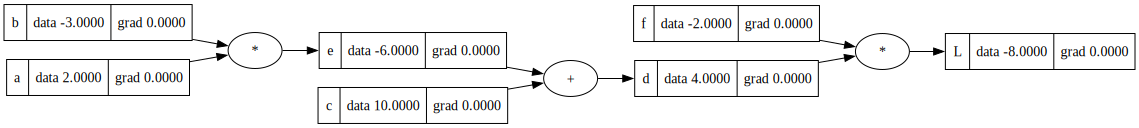

In [10]:
draw_dot(L)

In [11]:
L.grad = 1.0

L = d * f

dL/dd = f

(f(x+h)-f(x))/h

((d+h)*f - d*f)/h

(d*f + h*f - d*f)/h

(h*f)/h

f

In [ ]:
f.grad = 4.0
d. grad = -2.0

**Most important derivative in backprop**

dL / dc

d = c + e

dd/dc = 1.0 (this is the local derivative - we need the final derivative)
dd/de = 1.0
 
Based on the chain rule, we can multiple dd/dc and dL/dd to get dL/dc:

dd/dc * dL/dd = dL/dc
1.0 * -2.0 = -2.0

This shows that plus nodes just route the local gradient forward

In [15]:
c.grad = -2.0
e.grad = -2.0

dL/de = -2.0

e = a * b
de/da = b
de/db = a

dL/da = (dL/de) * (de/da)

In [17]:
a.grad=(-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [19]:
# Trying to increase L

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


### Summary

Backpropogation is just the recursive multiplication of local derivatives.

### 3. Backpropogation through a neuron

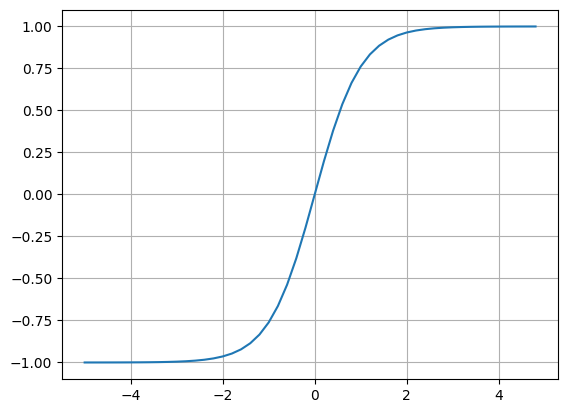

In [21]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [7]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1*w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
n.backward()

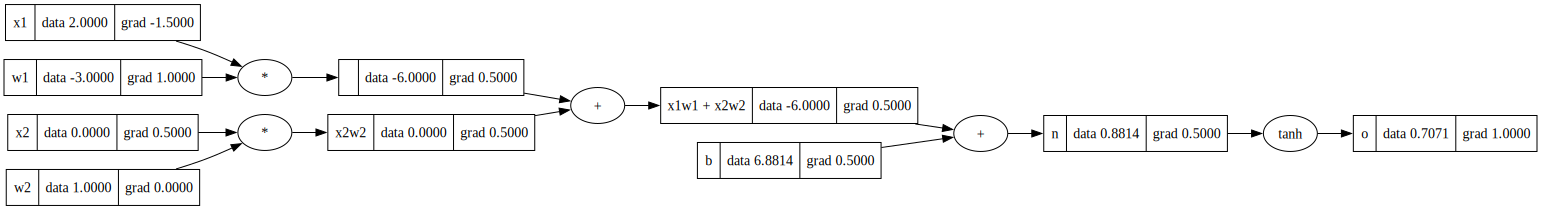

In [9]:
draw_dot(o)

#### Implementing another formula for tanh

In [92]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1*w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label='o'
o.backward()

In [ ]:
draw_dot(o)

In [24]:
o.grad = 1.0

o = tanh(n)

do/dn = 1 - tanh(n)**2 = 1 - o\**2

In [25]:
1 - o.data**2

0.4999999999999999

In [26]:
n.grad = 0.5

The gradient of n will flow all the down to x1w1 and x2w2, since it's all plus operations

In [28]:
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad  = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

**Redoing backprop with the backward() function**

In [35]:
o.grad = 1.0 # setting this to 1 because out.grad is initialized as 0, and self.grad here is (1 - t**2) * out.grad, which would just be 0 if we dont change it
o._backward()
n._backward()
b._backward() # nothing would happen since b is a leaf node
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

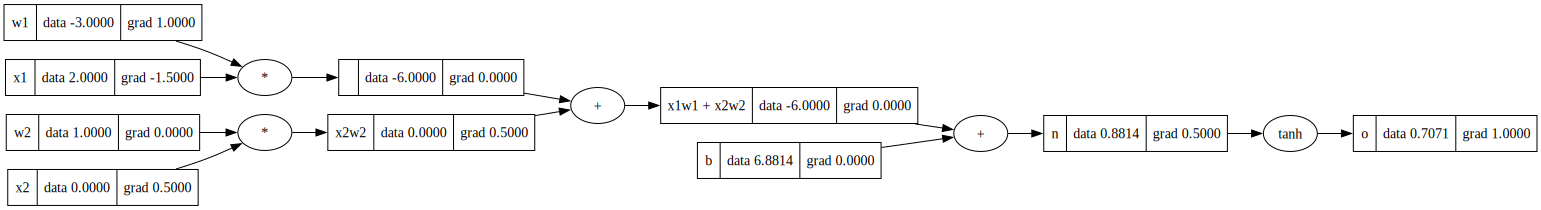

In [34]:
draw_dot(o)

**3. Topological Map**

We're arranging the nodes from left to right to ensure that all the child nodes are processed before o.

In [62]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o) # by calling build_topo on o, we start with it and recursively apply build_topo on all children on o, going to the left
print(topo)

for node in reversed(topo):
    node._backward()
    
# now we don't have to call __backward() on each node manually
# we added this to the Value class as .backward()

[Value(data=6.881373587019543), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [59]:
# Now that we added to the functionality to the class, we can call directly o.backward()
o.backward()

Python(73442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


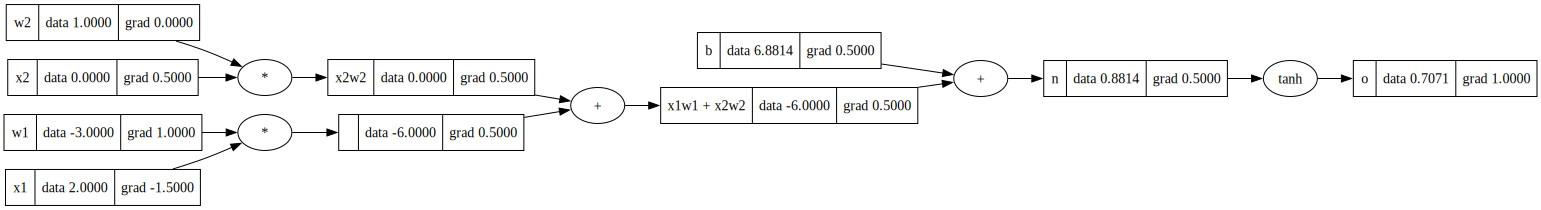

In [60]:
draw_dot(o)

### 4. Using PyTorch to implement the same thing

In [101]:
import torch

# Micrograd is a scalar-driven engine and only works with scalars, whereas PT works with tensors, which are n-dimensional arrays of scalars
 # casting it to double because Python uses double as the default for scalars, whereas PT tensors are in float32
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True # these are set to False by default for efficiency, since leaf nodes don't require gradients
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())
print('x1', x1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
w1 1.0000002567688737
x1 -1.5000003851533106


### 5. Building a 2-Layer MLP w/ Micrograd

In [576]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # assigns a random weight between -1 and 1 to the neuron
        self.b = Value(random.uniform(-1,1)) # assings a random bias between -1 and 1 to the neuron
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # zip creates multiple tuples of (w, x)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer: 
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # initalizes the input number of neurons for each output

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # returns an array with the dimensions of the output, since the neurons are processed
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # code above is same as code below:

        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Value(data=0.6018601765892704)

In [ ]:
# initializing the MLP

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

In [577]:
# input data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6018601765892704),
 Value(data=0.6699112297224608),
 Value(data=0.5020150565777047),
 Value(data=0.6769493046493635)]

In [578]:
# implementing mean squared error loss function
loss = sum(((yout - ygt)**2) for ygt, yout in zip(ys, ypred))
loss

Value(data=5.307529816091363)

In [301]:
# backward pass
loss.backward()

In [174]:
n.layers[0].neurons[0].w[0].grad

0.6138550006642206

In [175]:
n.layers[0].neurons[0].w[0].data

0.24050515701139075

In [245]:
# gradient descent
for p in n.parameters():
    p.data += 0.1 * p.grad # 
# the gradient is a vector pointing in the direction of increasing the loss, so we want to go in the opposite direction, which is why 0.01 is negative

In [687]:
# training loop
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0 
        # we have to set grad to zero because we initially set self.grad in Value to 0 and the gradients propagate from that, so if we don't reset it to zero every time, the training steps will become excessively large
    loss.backward()

    # gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.00032322596593387944
1 0.00032306695226960616
2 0.0003229080924296258
3 0.0003227493861922393
4 0.00032259083333615804
5 0.0003224324336405267
6 0.0003222741868849146
7 0.00032211609284929965
8 0.00032195815131409874
9 0.0003218003620601396
10 0.000321642724868659
11 0.0003214852395213222
12 0.0003213279058002134
13 0.00032117072348782045
14 0.0003210136923670574
15 0.00032085681222124
16 0.00032070008283410697
17 0.0003205435039898028
18 0.00032038707547288146
19 0.00032023079706831555


In [688]:
# output values
ypred

[Value(data=0.992164825791728),
 Value(data=-0.9898375631318539),
 Value(data=-0.9917238653107824),
 Value(data=0.9906687989143295)]